# ERA5 comparison with CMIP6 models

In this tutorial we will compare the ERA5 reanalysis to CMIP6 model outputs. To do so, you will choose a model from your country for example.

Getting CMIP6 data can be a bit painful via the official [ESGF portal](https://esgf-node.llnl.gov/search/cmip6/). The easiest way is usually to use the data directly from a computing center. In this tutorial, we will use the [instake-esm](https://intake-esm.readthedocs.io/en/stable/) package that allow to directly load CMIP6 data with Python: https://intake-esm.readthedocs.io/en/stable/user-guide/cmip6-tutorial.html

This is made possible thanks to partnership with Google Cloud: [New climate model data now in Google Public Datasets](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets). This is rather designed to work on [Pangeo-Cloud](https://pangeo.io/cloud.html) where the servers are directly connected to the data. However we can access it from anywhere with less performance. Note that intake can also be installed in your data center if data are already there.

## Import packages

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import intake
import pprint
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

# Import some extra functions from utils folder
import sys
sys.path.insert(1, 'utils') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
Virtual memory usage - total: 30 GB / available: 9 GB / percent used: 70.4 %


## Loading a catalog

In [2]:
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


## Catalog Contents

In [3]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


## Finding unique entries

In [10]:
unique = col.unique()
# unique["source_id", "experiment_id", "table_id"]
unique["source_id"]

['CMCC-CM2-HR4',
 'EC-Earth3P-HR',
 'HadGEM3-GC31-MM',
 'HadGEM3-GC31-HM',
 'HadGEM3-GC31-LM',
 'EC-Earth3P',
 'ECMWF-IFS-HR',
 'ECMWF-IFS-LR',
 'HadGEM3-GC31-LL',
 'CMCC-CM2-VHR4',
 'GFDL-CM4',
 'GFDL-AM4',
 'IPSL-CM6A-LR',
 'E3SM-1-0',
 'CNRM-CM6-1',
 'GFDL-ESM4',
 'GFDL-ESM2M',
 'GFDL-CM4C192',
 'GFDL-OM4p5B',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'CNRM-ESM2-1',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'MIROC6',
 'AWI-CM-1-1-MR',
 'EC-Earth3-LR',
 'IPSL-CM6A-ATM-HR',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1-HR',
 'MRI-ESM2-0',
 'SAM0-UNICON',
 'GISS-E2-1-G-CC',
 'UKESM1-0-LL',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'CanESM5',
 'CanESM5-CanOE',
 'INM-CM4-8',
 'INM-CM5-0',
 'NESM3',
 'MPI-ESM-1-2-HAM',
 'CAMS-CSM1-0',
 'MPI-ESM1-2-LR',
 'MPI-ESM1-2-HR',
 'MRI-AGCM3-2-H',
 'MRI-AGCM3-2-S',
 'MCM-UA-1-0',
 'INM-CM5-H',
 'KACE-1-0-G',
 'NorESM2-LM',
 'FGOALS-f3-H',
 'FGOALS-g3',
 'MIROC-ES2L',
 'FIO-ESM-2-0',
 'NorCPM1',
 'NorESM1-F',
 'MPI-ESM1-2-XR',
 'CESM1-1-CAM5-CMIP5',
 'E3SM-1-1',
 'KIOST

## Searching for specific datasets

In the example below, we are are going to search for the following:
- variables: `tas` which stands for near-surface (usually, 2 meter) air temperature ([IPCC Standard Output from Coupled Ocean-Atmosphere GCMs](https://pcmdi.llnl.gov/mips/cmip3/variableList.html))

- experiments: `['historical', 'sspxxx']`:
    - `historical`: all forcing of the recent past.
    - `sspxxx`: emission-driven Shared Socioeconomic Pathways ([O'Neill et al, 2016](https://doi.org/10.5194/gmd-9-3461-2016)).


- table_id: `Amon` which stands for monthly mean variables on the atmosphere grid.

- source_id: `IPSL-CM6A-LR` which stands for a model (choose one from your country for example).
    - search your country from here: [CMIP6_institution_id](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_institution_id.html)
    - find one model: [CMIP6_source_id](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_source_id.html) (check that `ScenarioMIP` is available)
    

- member_id: `r1i1p1f1` to get the first member.

For more details on the CMIP6 vocabulary, please check this [website](http://clipc-services.ceda.ac.uk/dreq/index.html), and [Core Controlled Vocabularies (CVs) for use in CMIP6](https://github.com/WCRP-CMIP/CMIP6_CVs) GitHub repository.

In [12]:
# model_name = ### choose one model from your country

# cat = col.search(
#     experiment_id=["historical", "ssp119", "ssp126", "ssp245", "ssp370", "ssp585"],
#     table_id="Amon",
#     variable_id="tas",
#     source_id=model_name,
#     member_id="r1i1p1f1"
# )

# cat

In [13]:
model_name = 'IPSL-CM6A-LR'

cat = col.search(
    experiment_id=["historical", "ssp119", "ssp126", "ssp245", "ssp370", "ssp585"],
    table_id="Amon",
    variable_id="tas",
    source_id=model_name,
    member_id="r1i1p1f1"
)

cat

,unique
activity_id,2
institution_id,1
source_id,1
experiment_id,6
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,6
dcpp_init_year,0


In [14]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
1,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp245,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
2,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
3,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp119,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190410
4,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190903


## Loading datasets

In [15]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [16]:
[key for key in dset_dict.keys()]

['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp119.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp370.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr']

In [18]:
# ds = dset_dict[###] # Take the historical key of the model you have chosen
# ds

In [19]:
ds = dset_dict["CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr"]
ds

<xarray.Dataset>
Dimensions:         (lat: 143, lon: 144, member_id: 1, dcpp_init_year: 1,
                     time: 1980, axis_nbounds: 2)
Coordinates:
    height          float64 ...
  * lat             (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon             (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: axis_nbounds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 143, 144), meta=np.ndarray>
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr

## Visualize data

In [20]:
model = ds.tas.isel(member_id=0) - 273.15
model

<xarray.DataArray 'tas' (dcpp_init_year: 1, time: 1980, lat: 143, lon: 144)>
dask.array<sub, shape=(1, 1980, 143, 144), dtype=float32, chunksize=(1, 600, 143, 144), chunktype=numpy.ndarray>
Coordinates:
    height          float64 ...
  * lat             (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon             (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id       <U8 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

### Exercise: Compute climatology and plot it

In [21]:
# clim_model = ###

### Solution

In [27]:
clim_model = model.mean('time').load().squeeze()

/home/lalandmi/miniconda3/envs/numlab/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


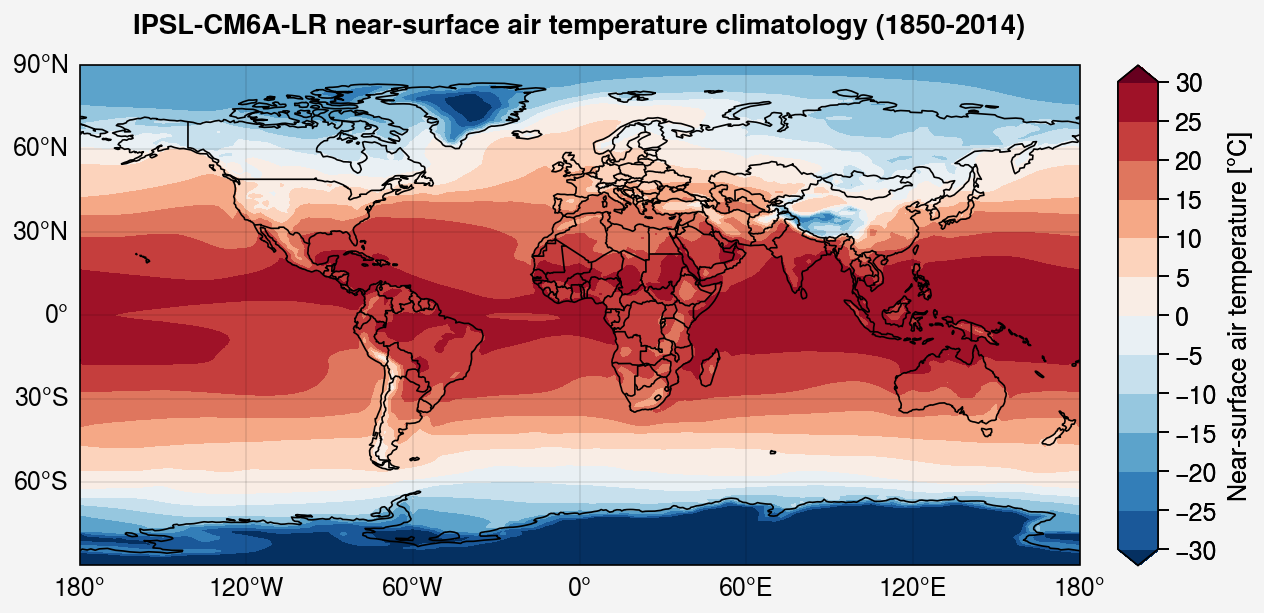

In [28]:
cmap='RdBu_r'
levels=plot.arange(-30,30,5)
extend='both'

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=5)

axs[0].contourf(
    clim_model, colorbar='r', cmap=cmap, levels=levels, extend=extend, 
    colorbar_kw={'label': 'Near-surface air temperature [°C]'}, globe=True
)

year_start = str(model['time.year'].min().values.item(0))
year_end = str(model['time.year'].max().values.item(0))

axs.format(
    labels=True, coast=True, borders=True,
    suptitle=model_name+' near-surface air temperature climatology ('+year_start+'-'+year_end+')'
)

## Compare ERA5 to model
See back `02_ERA5.ipynb`

### Download ERA5

1. Go to https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5
2. Search `ERA5 monthly averaged data on single levels from 1979 to present`
3. Download:
    - Product type: Monthly averaged reanalysis
    - Variable: 2m temperature
    - Select all years (except 2021) / months / time
    - Geographical area: Whole available region
    - Format: NetCDF (experimental)
4. Login/register to submit request (create an account if you don't have one)
5. Go back down on the page and click on Submit Form
6. Click on download, cancel, then right click on the download button and copy the link path, then paste it on the cell bellow besides the `wget` command

Remark: It should be around 1Go

In [ ]:
!wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache/ba75d865e7d381144835dde0e06c0028.nc

7. Rename the downloaded file to `ERA5.nc`

In [29]:
ds = xr.open_dataset('ERA5.nc', chunks={"longitude": 360, "latitude": 360}) \
        .rename({'longitude': 'lon', 'latitude': 'lat'})
obs = ds.t2m - 273.15

In [31]:
obs

<xarray.DataArray 't2m' (date: 1018, lat: 721, lon: 1440)>
dask.array<sub, shape=(1018, 721, 1440), dtype=float32, chunksize=(1018, 360, 360), chunktype=numpy.ndarray>
Coordinates:
    number   int64 ...
  * date     (date) int64 19400101 19400201 19400301 ... 20240901 20241001
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    expver   (date) object dask.array<chunksize=(1018,), meta=np.ndarray>

In [32]:
obs['date'] = pd.date_range('1940-01', '2024-10', freq='MS')
obs = obs.rename({'date': 'time'})
obs = obs.sel(time=slice('1940', '2023'))
obs

<xarray.DataArray 't2m' (time: 1008, lat: 721, lon: 1440)>
dask.array<getitem, shape=(1008, 721, 1440), dtype=float32, chunksize=(1008, 360, 360), chunktype=numpy.ndarray>
Coordinates:
    number   int64 ...
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2023-12-01
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    expver   (time) object dask.array<chunksize=(1008,), meta=np.ndarray>

## Select same time period
Before making the comparison, be aware that the two data sets are not from the same time period.

### Exercise
Check the period of the model data and ERA5 to choose a common period

In [ ]:
# clim_obs = ###
# clim_model = ###

### Solution

In [34]:
# - model: 1979-2014
# - obs: 1850-2023

period = slice('1979', '2014')

# Test that both data sets are having the same size
np.testing.assert_equal(
    obs.sel(time=period).time.size,
    model.sel(time=period).time.size
)

clim_obs = obs.sel(time=period).mean('time').load()
clim_model = model.sel(time=period).mean('time').load().squeeze()

## Regrid ERA5 to the model grid
We cannot directly compare ERA5 to the model because they are not on the same grid. For that we will have to make a regrid. Several options:
- use command line tools like [CDO](https://code.mpimet.mpg.de/projects/cdo/)
- use [xESMF](https://xesmf.readthedocs.io/en/latest/) which is an adaptation of a Fortran program in Python and takes into account the sphericity of the Earth (I recommend, but it only works on Linux and maybe Mac)
- for non-Linux users, you can also directly use the [`.interp()`](https://xarray.pydata.org/en/stable/user-guide/interpolation.html#example) function of xarray, which does not take into account the sphericity of the Earth but does the job.

### For Linux users (xESMF)
Check: [Regrid between rectilinear grids](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html)

In [36]:
# Create a regridder
regridder = xe.Regridder(
    clim_obs, clim_model, 'bilinear', periodic=True
    #clim_obs, clim_model, 'bilinear', periodic=True, reuse_weights=True
)

In [37]:
# Make the regrid
clim_obs_regrid = regridder(clim_obs)
clim_obs_regrid

<xarray.DataArray (lat: 143, lon: 144)>
array([[-45.475693 , -45.475693 , -45.475693 , ..., -45.475693 ,
        -45.475693 , -45.475693 ],
       [-45.082817 , -45.154278 , -45.225983 , ..., -44.890762 ,
        -44.943363 , -45.0127   ],
       [-44.377403 , -44.49904  , -44.610317 , ..., -44.164715 ,
        -44.29309  , -44.322018 ],
       ...,
       [-13.582892 , -13.552754 , -13.526791 , ..., -13.671157 ,
        -13.662175 , -13.624957 ],
       [-13.856027 , -13.849502 , -13.843847 , ..., -13.8814945,
        -13.875488 , -13.8655   ],
       [-14.100254 , -14.100254 , -14.100254 , ..., -14.100254 ,
        -14.100254 , -14.100254 ]], dtype=float32)
Coordinates:
    number     int64 0
    member_id  <U8 'r1i1p1f1'
    height     float64 2.0
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    regrid_method:  bilinear

### For non-Linux users (xarray)
Check: https://xarray.pydata.org/en/stable/user-guide/interpolation.html#example

In [ ]:
clim_obs_regrid = clim_obs.interp(lat=clim_model.lat, lon=clim_model.lon)
clim_obs_regrid

### Plot

In [42]:
import warnings
warnings.filterwarnings("ignore")

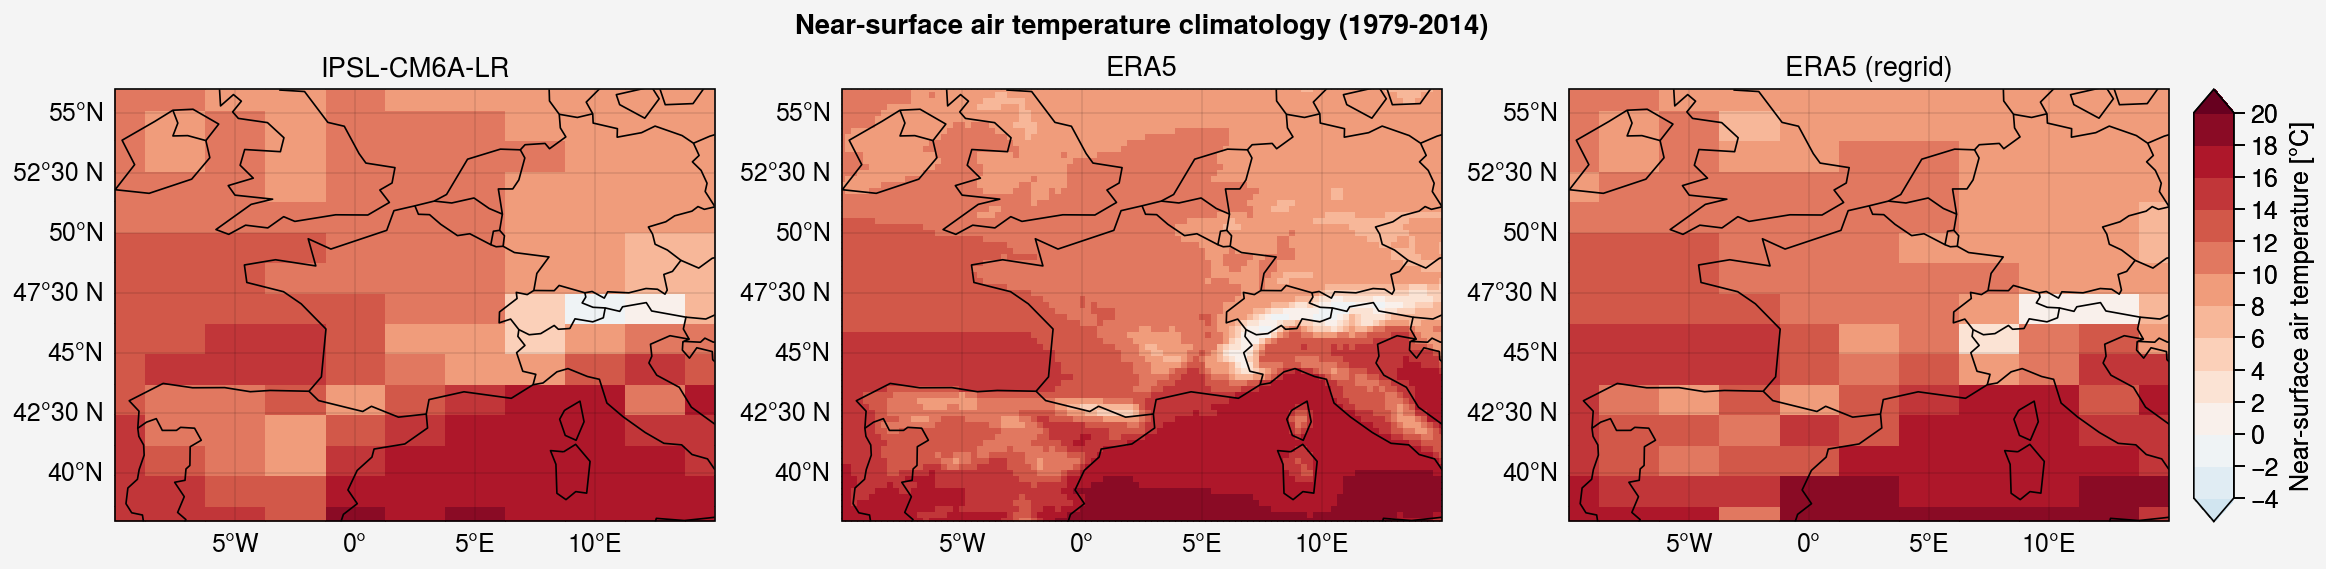

In [43]:
cmap='RdBu_r'
levels=plot.arange(-4,20,2)
extend='both'
norm='div'

# Make a zoom on your country
latmin=38 ; latmax=56 ; lonmin=-10 ; lonmax=15

fig, axs = plot.subplots(nrows=1, ncols=3, proj='cyl', axwidth=3)
  
m = axs[0].pcolormesh(clim_model, cmap=cmap, levels=levels, extend=extend, norm=norm)
axs[0].format(title=model_name) 

axs[1].pcolormesh(clim_obs, cmap=cmap, levels=levels, extend=extend, norm=norm)
axs[1].format(title='ERA5') 

axs[2].pcolormesh(clim_obs_regrid, cmap=cmap, levels=levels, extend=extend, norm=norm)
axs[2].format(title='ERA5 (regrid)')

fig.colorbar(m, label='Near-surface air temperature [°C]')

axs.format(
    labels=True, coast=True, borders=True,
    suptitle='Near-surface air temperature climatology ('+period.start+'-'+period.stop+')',
    latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
)

## Plot the global bias
Or take a sub-zone if it's too heavy

### Exercise
Make a figure showing the annual climatological bias in surface temperature between the model and ERA5 (model - ERA5).

### Solution

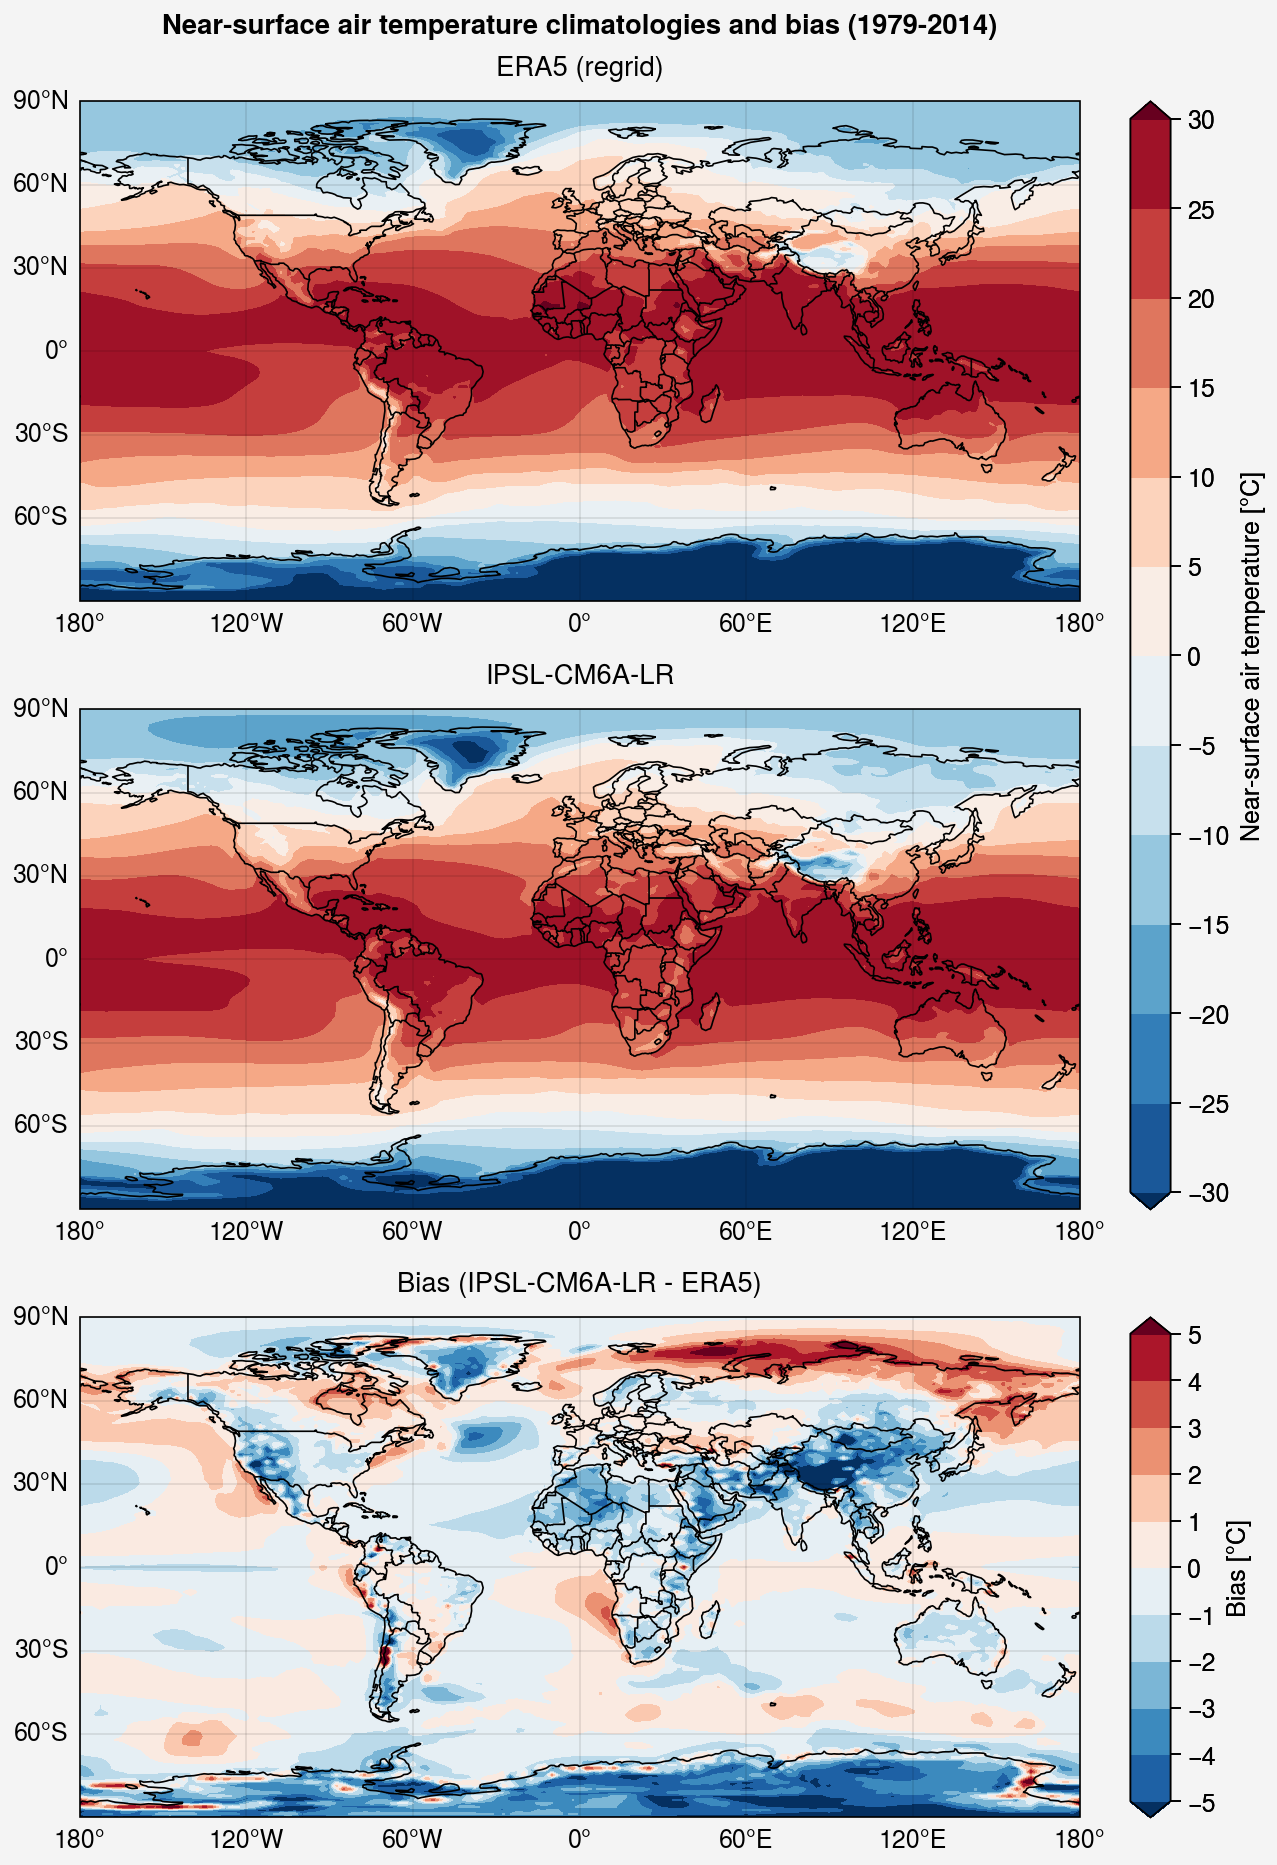

In [44]:
cmap='RdBu_r'
levels=plot.arange(-30,30,5)
extend='both'

fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

# Obs
m1 = axs[0].contourf(
    clim_obs_regrid, cmap=cmap, levels=levels, extend=extend, globe=True
)
axs[0].format(title='ERA5 (regrid)')

# Model
axs[1].contourf(
    clim_model, cmap=cmap, levels=levels, extend=extend, globe=True
)
axs[1].format(title=model_name)

# Bias (model - obs)
m2 = axs[2].contourf(
    clim_model-clim_obs_regrid, cmap=cmap, 
    levels=plot.arange(-5, 5, 1), extend=extend, globe=True
)
axs[2].format(title='Bias ('+model_name+' - ERA5)')

fig.colorbar(m1, rows=(1, 2), label='Near-surface air temperature [°C]')
fig.colorbar(m2, row=3, label='Bias [°C]')

axs.format(
    labels=True, coast=True, borders=True,
    suptitle='Near-surface air temperature climatologies and bias ('+period.start+'-'+period.stop+')'
)

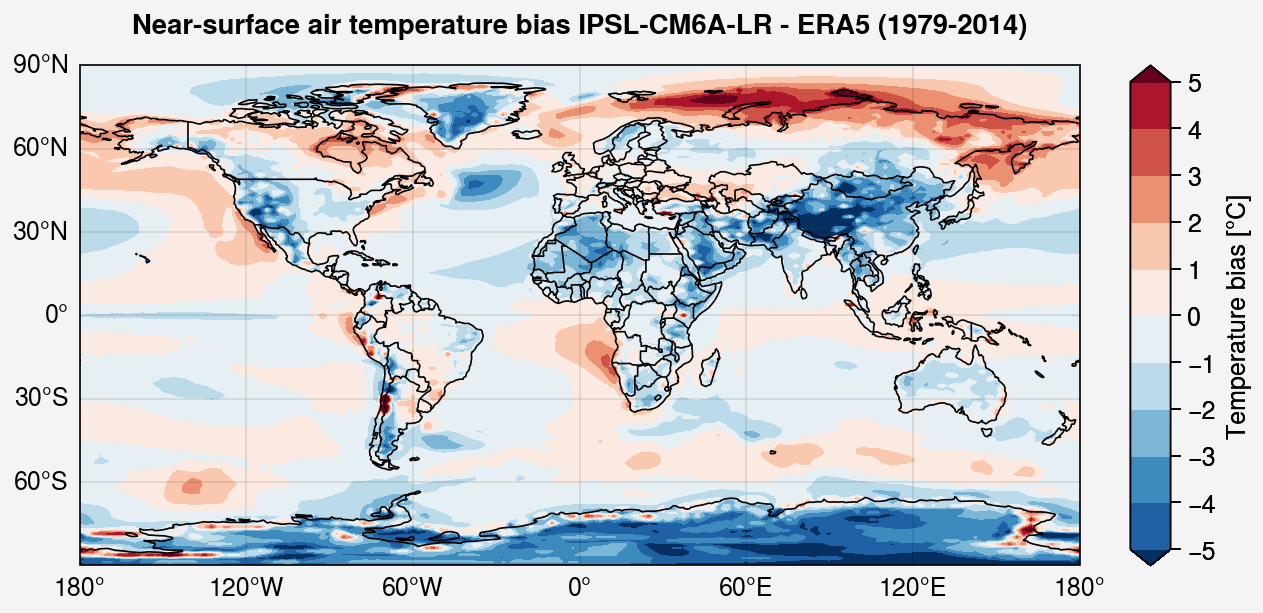

In [45]:
cmap='RdBu_r'
levels=plot.arange(-30,30,5)
extend='both'

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=5)

# Bias (model - obs)
m = axs[0].contourf(
    clim_model-clim_obs_regrid, cmap=cmap, 
    levels=plot.arange(-5, 5, 1), extend=extend, globe=True
)

fig.colorbar(m, label='Temperature bias [°C]')

axs.format(
    labels=True, coast=True, borders=True,
    suptitle='Near-surface air temperature bias '+model_name+' - ERA5 ('+period.start+'-'+period.stop+')'
)
# fig.save('img/'+model_name+'_tas_bias_'+period.start+'-'+period.stop+'.jpg')

## Plot global time series
If too heavy take a sub-zone

In [46]:
# Resample by year
obs_year = obs.resample(time='Y').mean('time').load()
model_year = model.resample(time='Y').mean('time').load().squeeze()

In [47]:
# Make spatial average
ts_obs = (u.spatial_average(obs_year)).load()
ts_model = (u.spatial_average(model_year)).load()

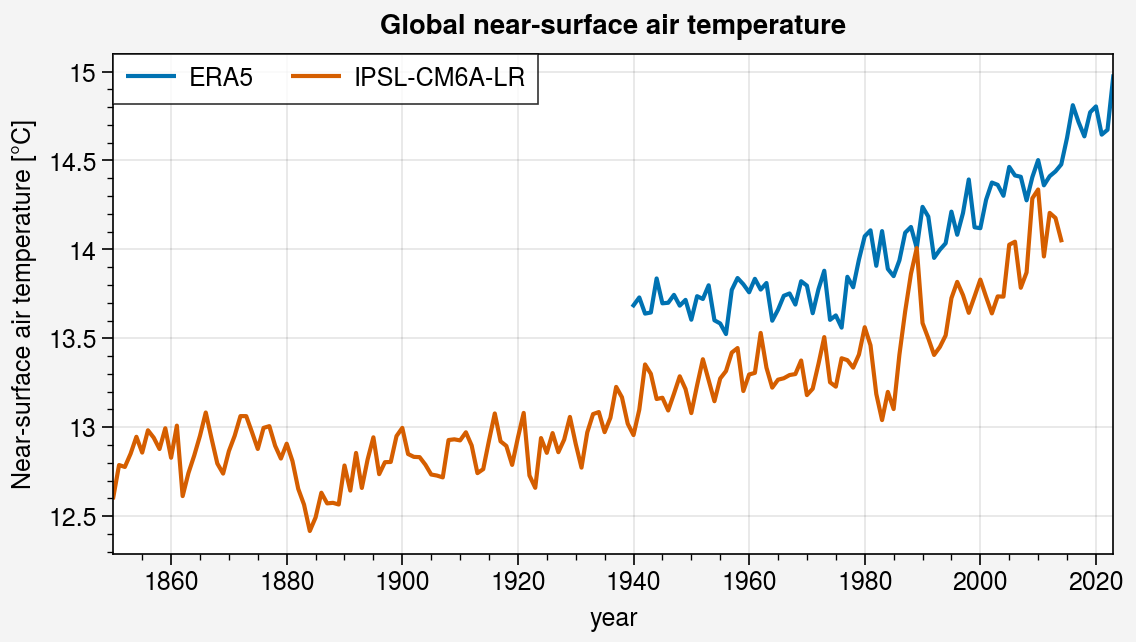

In [49]:
fig, axs = plot.subplots(axwidth=5, refaspect=2)

axs[0].plot(ts_obs['time.year'], ts_obs, label='ERA5')
axs[0].plot(ts_model['time.year'], ts_model, label=model_name)

    
axs[0].legend()

axs.format(
    xlabel='year',
    ylabel='Near-surface air temperature [°C]',
    suptitle='Global near-surface air temperature',
)

## Add projections
Take anomalies with respect to a common time period, e.g. 1995-2014, to get rid of the global bias.

Check this for using IPCC Color Palettes: https://pyam-iamc.readthedocs.io/en/stable/tutorials/ipcc_colors.html (this package is not installed here)

Get back the keys to load scenarios data sets!

In [50]:
[key for key in dset_dict.keys()]

['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp119.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp370.Amon.gr',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr']

### Exercise
Make a figure showing the near-surface air temperature anomalies over the historical period and the future period up to 2100 for all scenarios available for your model.

### Solution

In [51]:
list_scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
colors = ['#00a9cf', '#003466', '#f69320', '#df0000', '#980002']

In [55]:
temp = []
for scenario in list_scenarios:
    ds = dset_dict["ScenarioMIP.IPSL.IPSL-CM6A-LR."+scenario+".Amon.gr"]
    da = ds.tas.isel(member_id=0) - 273.15
    temp.append(u.spatial_average(da.resample(time='Y').mean('time').squeeze()))

# Concatenate results
ts_model_future = xr.concat(temp, pd.Index(list_scenarios, name='scenario')).load()

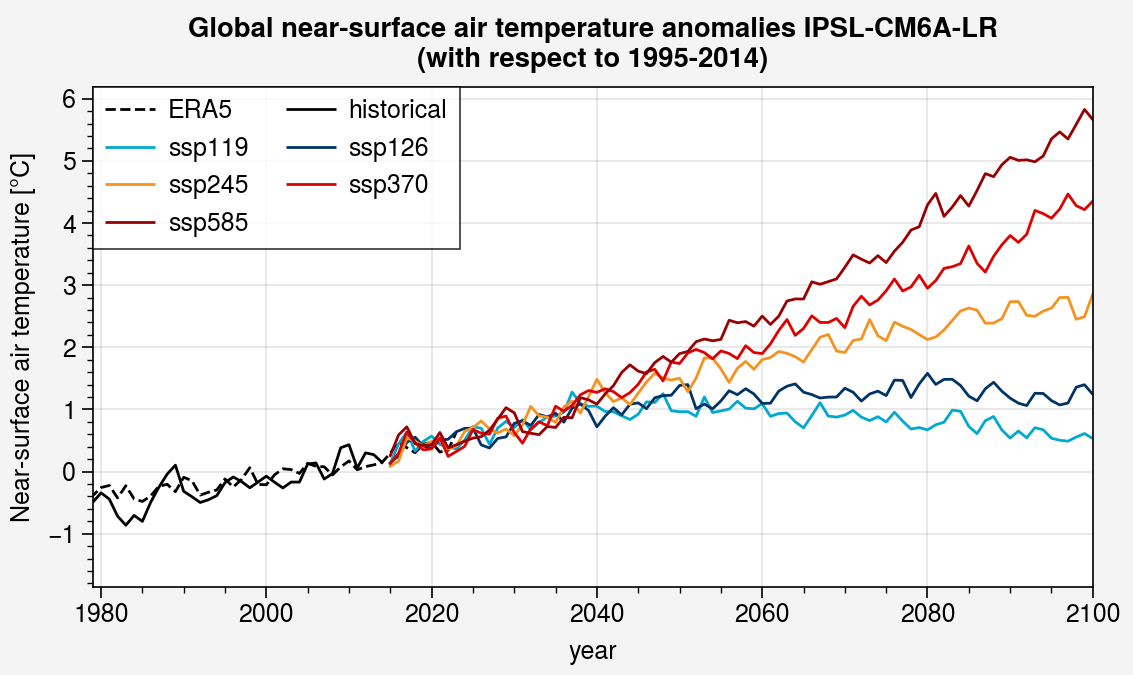

In [57]:
ref_period = slice('1995', '2014')
ref_obs = ts_obs.sel(time=ref_period).mean('time')
ref_model = ts_model.sel(time=ref_period).mean('time')

linewidth = 1

fig, axs = plot.subplots(axwidth=5, refaspect=2)

# Past
axs[0].plot(
    ts_obs['time.year'], 
    ts_obs-ref_obs, 
    label='ERA5', color='k', linewidth=linewidth, linestyle='--'
)
axs[0].plot(
    ts_model['time.year'], 
    ts_model-ref_model, 
    label='historical', color='k', linewidth=linewidth
)

# Future
for i, scenario in enumerate(list_scenarios):
    axs[0].plot(
        ts_model_future['time.year'], 
        ts_model_future.sel(scenario=scenario) - ref_model, 
        label=scenario, color=colors[i], linewidth=linewidth
    )
    
axs[0].legend(ncols=2)

axs.format(
    xlabel='year',
    ylabel='Near-surface air temperature [°C]',
    suptitle='Global near-surface air temperature anomalies '+model_name+'\n(with respect to 1995-2014)',
    xlim=(1979,2100)
)
# fig.save('img/'+model_name+'_ts_tas_anomalies_projections.jpg')

## Bonus
If you still have time, try adding models or members to add uncertainties (to add envelopes to the curves, you can look at the [`fill_between()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) function of matplotlib or otherwise proplot implements it directly in a simplified way: https://proplot.readthedocs.io/en/v0.6.4/1dplots.html#Shading-and-error-bars). 

Feel free to do any other analysis you are interested in!